In [2]:
import pandas as pd

# Load the CSV file
file_path = '/Users/gracekight/Desktop/customer_booking.csv'

data = pd.read_csv(file_path, encoding='latin1')

# Create a copy of the filtered data to ensure we are working with a fresh, independent DataFrame
filtered_data = data[
    (data['sales_channel'] == 'Internet') & (data['trip_type'] == 'RoundTrip')
].copy()

# Select the necessary columns and rename them in one step (no inplace)
result_df = filtered_data[['num_passengers', 'purchase_lead', 'booking_complete']]

# Rename columns by directly reassigning the DataFrame
result_df = result_df.rename(columns={
    'num_passengers': 'size',
    'purchase_lead': 'lead_time',
    'booking_complete': 'booking'
})

# Set the index to start at 1
result_df.index = range(1, len(result_df) + 1)

# Check the resulting DataFrame
print(result_df.head())



   size  lead_time  booking
1     2        262        0
2     1        112        0
3     2        243        0
4     1         96        0
5     2         68        0


In [3]:
# Check the column names to verify exact names
print(result_df.columns)


Index(['size', 'lead_time', 'booking'], dtype='object')


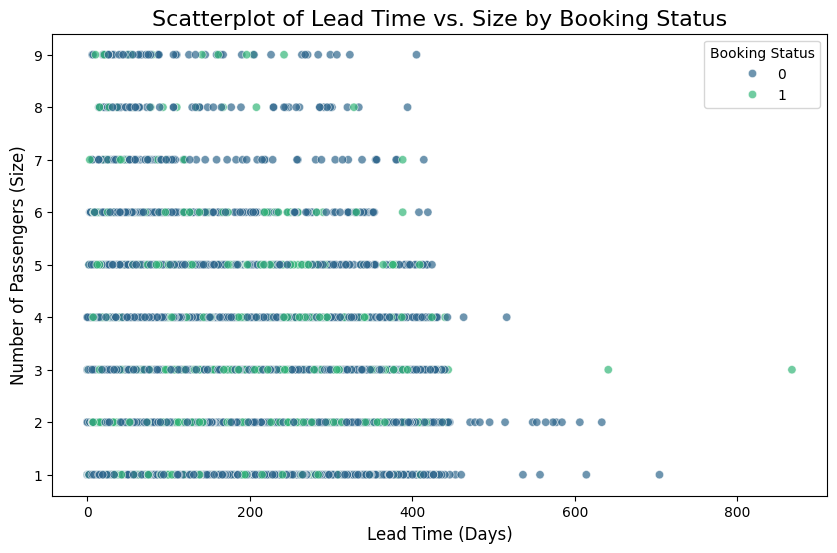

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=result_df,
    x='lead_time',  # Independent variable
    y='size',       # Independent variable
    hue='booking',  # Dependent variable (classification target)
    palette='viridis',  # Color palette for classes
    alpha=0.7       # Transparency for overlapping points
)

# Add labels and title
plt.title('Scatterplot of Lead Time vs. Size by Booking Status', fontsize=16)
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Number of Passengers (Size)', fontsize=12)
plt.legend(title='Booking Status', loc='upper right')

# Show the plot
plt.show()


****ANALYSIS OF SCATTERPLOT****

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [6]:
# Step 1: Prepare your data
# Example: Create a synthetic classification dataset
# Replace this with your actual dataset if you have it (e.g., `result_df` or another DataFrame)
#X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)


X = result_df[['lead_time', 'size']]  # Features
y = result_df['booking']  # Target

# Step 2: Initialize models with parameters
logreg = LogisticRegression(max_iter=100, random_state=42)
dtree = DecisionTreeClassifier(max_depth=10, random_state=42)
gnb = GaussianNB()

# Step 3: Perform cross-validation for each classifier

# Logistic Regression: Cross-validation score
logreg_cv = cross_val_score(logreg, X, y, cv=10)
print(f'Logistic Regression CV Mean Accuracy: {np.mean(logreg_cv):.4f}')

# Decision Tree Classifier: Cross-validation score
dtree_cv = cross_val_score(dtree, X, y, cv=10)
print(f'Decision Tree CV Mean Accuracy: {np.mean(dtree_cv):.4f}')

# Gaussian Naive Bayes: Cross-validation score
gnb_cv = cross_val_score(gnb, X, y, cv=10)
print(f'Gaussian Naive Bayes CV Mean Accuracy: {np.mean(gnb_cv):.4f}')


Logistic Regression CV Mean Accuracy: 0.8441
Decision Tree CV Mean Accuracy: 0.8429
Gaussian Naive Bayes CV Mean Accuracy: 0.8415


*****BEST METHOD ANALYSIS:*****
Logistic regression has highest mean accuracy 

Optimal Tree Depth: 1


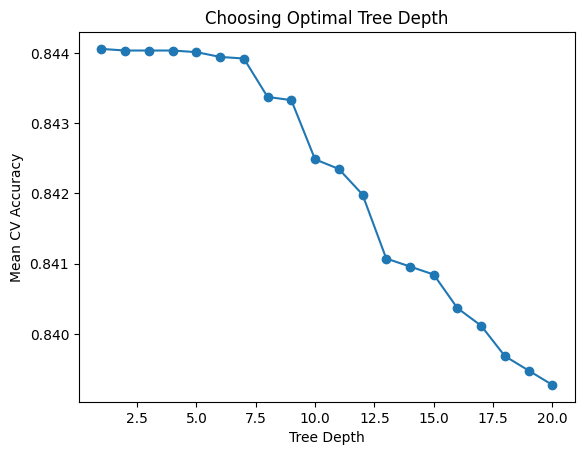

In [7]:
depth_range = range(1, 21)

# Store cross-validation scores
mean_scores = []

for depth in depth_range:
    # Create decision tree with specified depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    # Store mean score
    mean_scores.append(np.mean(scores))

# Find the optimal depth
optimal_depth = depth_range[np.argmax(mean_scores)]
print(f"Optimal Tree Depth: {optimal_depth}")

# Plot results (optional)
import matplotlib.pyplot as plt
plt.plot(depth_range, mean_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean CV Accuracy')
plt.title('Choosing Optimal Tree Depth')
plt.show()

In [8]:
import statsmodels.api as sm

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.432165
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                booking   No. Observations:                43901
Model:                          Logit   Df Residuals:                    43898
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                0.001650
Time:                        17:32:46   Log-Likelihood:                -18972.
converged:                       True   LL-Null:                       -19004.
Covariance Type:            nonrobust   LLR p-value:                 2.427e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7249      0.025    -68.408      0.000      -1.774      -1.675
lead_time     -0.0010      0.

RECOMMENDATION ??

In [9]:
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp


# Split the dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_clf.fit(X_train, y_train)

# Bias-Variance Decomposition
avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
    tree_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
)

# Results
print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
print(f"Average Bias: {avg_bias:.4f}")
print(f"Average Variance: {avg_variance:.4f}")

Average Expected Loss (MSE): 0.1559
Average Bias: 0.1559
Average Variance: 0.0000


INTERPRETATION

In [10]:
# Split the dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False, stratify=None
)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=1,random_state=42)
tree_clf.fit(X_train, y_train)

# Bias-Variance Decomposition
avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
    tree_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
)

# Results
print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
print(f"Average Bias: {avg_bias:.4f}")
print(f"Average Variance: {avg_variance:.4f}")

Average Expected Loss (MSE): 0.2072
Average Bias: 0.2072
Average Variance: 0.0000


In [11]:
from sklearn.ensemble import BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Iterate over different values of n_estimators
for n_estimators in [100]:
    # Initialize Bagging Classifier with DecisionTreeClassifier as the base estimator
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )
    bagging_clf.fit(X_train, y_train)

    # Bias-Variance Decomposition
    avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
        bagging_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
    )

    # Results
    print(f"Results with {n_estimators} estimators:")
    print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
    print(f"Average Bias: {avg_bias:.4f}")
    print(f"Average Variance: {avg_variance:.4f}")
    print("-" * 50)

Results with 100 estimators:
Average Expected Loss (MSE): 0.1697
Average Bias: 0.1616
Average Variance: 0.0174
--------------------------------------------------


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (16).

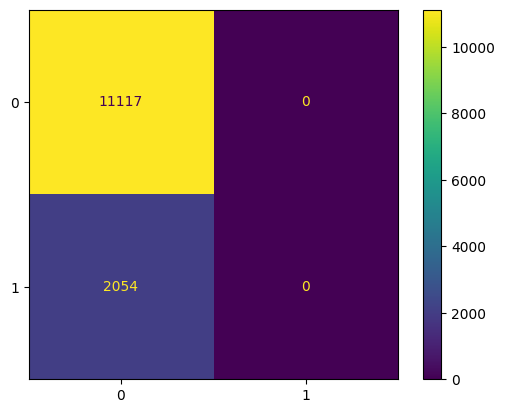

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split data into training (70%) and test (30%) sets with shuffle=True and stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

# Train a logistic regression model
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels='booking_complete')
disp.plot(cmap='viridis', values_format='d')

# Show the plot
plt.title("Confusion Matrix for Logistic Regression Classifier")
plt.show()

# Print the confusion matrix for further analysis
print("Confusion Matrix:")
print(cm)